# JSL49_01 (CF-900)

In [172]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
## Preparing some stuff
# Libraries
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib, json, codecs, scipy, scipy.constants
import matplotlib.pyplot as plt
import scipy.stats
import scipy.signal
from IPython.core.display import display, HTML
import mjsplot as mplt
import dateutil
import scipy.special
digamma = scipy.special.digamma

# Display
# display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

# Physical constants
e = scipy.constants.e
k_B = scipy.constants.Boltzmann
h = scipy.constants.h
hbar = scipy.constants.hbar
Rk = h/e**2
Phi_0 = h/e # Flux quantum

# Load data
d = {}
df = {}
def loadin(filename): # a way to load in many different files and keep track of them. 
    datafile = json.loads( codecs.open('../data/'+filename,'r','utf-8').read() )
    key = datafile['attr']['_file counter']
    d[key]= datafile
    df[key] = pd.DataFrame(datafile['data']) 

# Data analysis

In [30]:
# Model
def WAL_model(B,Bphi,Bso,Be):
    a = e**2/(2*np.pi**2*hbar)
    b = (Bso+Be)/B
    c = (4/3*Bso + Bphi)/B
    return a*(np.log(Bphi/B) - digamma(.5+Bphi/B))\
    + 2*a*(np.log(b) - digamma(.5+b))\
    - 3*a*(np.log(c) - digamma(.5+c))
def WAL_model2(B,Bphi,Bso,Be):
    a = e**2/(np.pi*h)
    B1 = Bphi+4/3*Bso
    B2 = Be
    B3 = B1
    B4 = Bphi
    return a*( digamma(.5+B1/B) - digamma(.5+B2/B) + .5*digamma(.5+B3/B) - .5*digamma(.5+B4/B))
# Data
def WAL_data(b,B,Vxx,Ibias,offset):
    G = Ibias/Vxx
    return scipy.interp(b,B-offset,G-np.max(G.values))

# Fitting

In [63]:
loadin('20180712T155357451Z-0126.json')
bz,vxx = df['0126']['Magnetic Field / T'],df['0126']['AC Voltage xx / V']
offset = bz[vxx.idxmin()]
B = np.linspace(1e-9,5e-3,501)
G = WAL_data(B,bz,vxx,20e-9,offset)

### All parameters run free

/Users/danielbouman/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


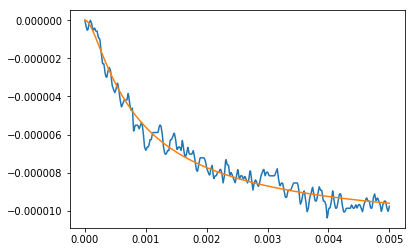

l_phi = 1.27 +- 4.80 um
l_SO = 1.20 +- 0.03 um
l_e = 1.09 +- 0.03 um.


In [64]:
p0 = [hbar/(4*e*l**2) for l in [1e-6,200e-9,600e-9]]
popt,pcov = scipy.optimize.curve_fit(WAL_model,B,G,p0=p0)
plt.plot(B,G)
plt.plot(B,WAL_model(B,*popt))
plt.show()
print('l_phi = {0:.2f} +- {3:.2f} um\nl_SO = {1:.2f} +- {4:.2f} um\nl_e = {2:.2f} +- {5:.2f} um.'
      .format(*np.array([1/np.sqrt(4*e*B/hbar) for B in popt])*1e6,*[1/np.sqrt(4*e*B/hbar)*1e6 for B in np.sqrt(np.diag(pcov))]))

### Gate dependent data (old)

In [11]:
loadin('20180704T184040960Z-0087.json')

/Users/danielbouman/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


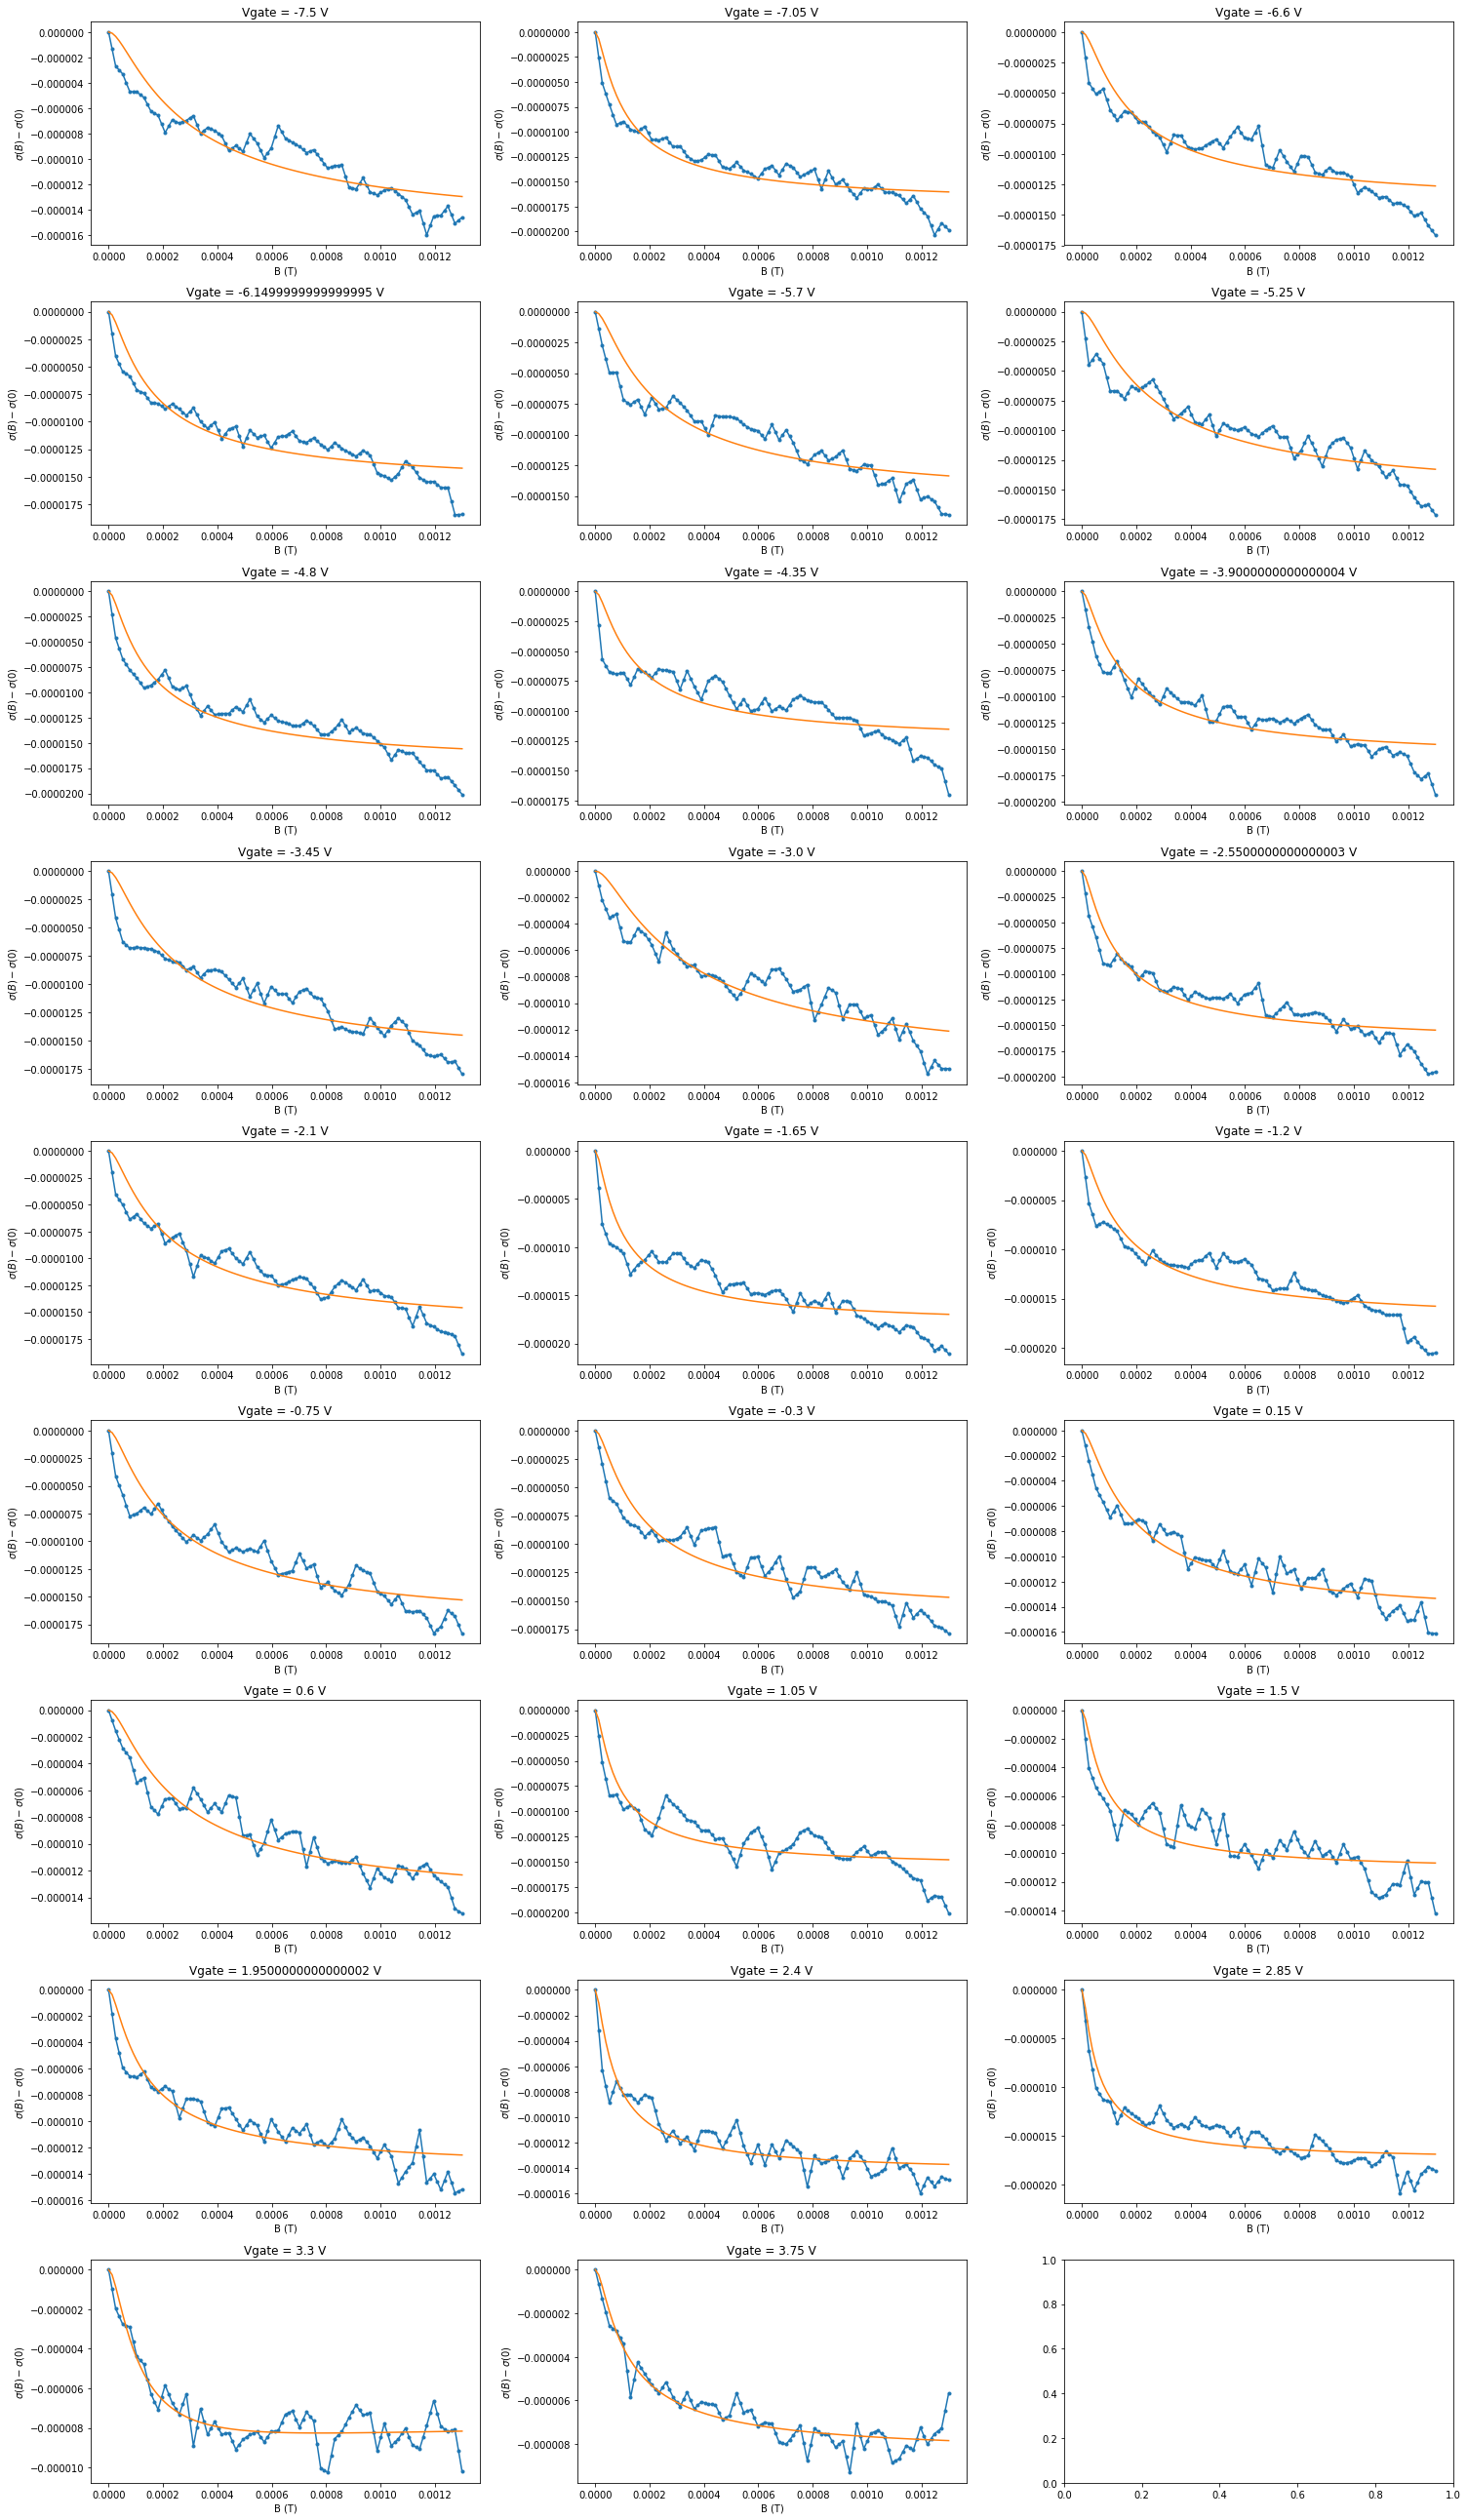

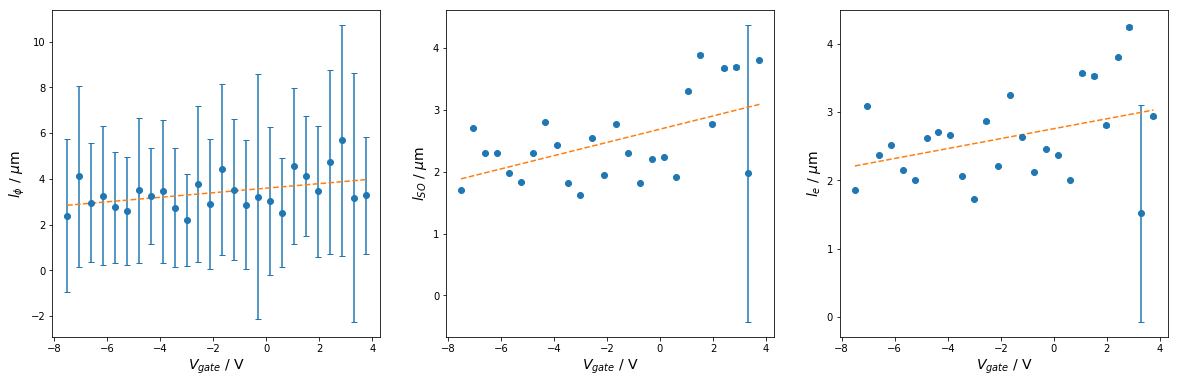

Mean values:
l_phi = 3.40 +- 3.22 um
l_SO = 2.48 +- 0.11 um
l_e = 2.62 +- 0.07 um

Fitted trends:
l_phi :  
9.95e-08 x + 3.59e-06
l_SO :  
1.069e-07 x + 2.684e-06
l_e :  
7.266e-08 x + 2.756e-06


In [60]:
#Plotting
subfigs = np.ceil(df['0087']['Gate dac 2 / mV'].unique().size)
if subfigs <= 3:
    rows,cols = 1,int(subfigs)
else:
    rows,cols = int(np.ceil(subfigs/3)),3
fig_wal,ax_wal = plt.subplots(nrows=rows,ncols=cols,figsize=(cols*7,rows*4))
ax_wal = sum(ax_wal.tolist(), [])

#Save fit data prep
l_fits = {}
l_fits_error = {}
l_vgate = []
for ax,(label,group) in zip(ax_wal,df['0087'].groupby('Gate dac 2 / mV')):
    bz,vxx = group['Magnet Z / T'],group['AC Voltage xx / V']
    offset = bz[vxx.idxmin()]
    graw = 4e-9/vxx
    Bmin = 1.3e-3
    
    ## Symmetrize
    b = np.linspace(-Bmin,Bmin,101)
    G_symm = (scipy.interp(b,bz-offset,graw)+scipy.interp(-b,bz-offset,graw)) / 2
    
    ## Fit
    B = np.linspace(1e-9,Bmin,101)
    G = scipy.interp(B,b,G_symm-np.max(G_symm))
    ini = [hbar/(4*e*l**2) for l in [1e-6,1e-6,1e-6]]
    popt,pcov = scipy.optimize.curve_fit(WAL_model,B,G,p0=ini)
    
    #Save fit data
    l_vgate.append(label/1e3*15)
    l_all = [1/np.sqrt(4*e*B/hbar) for B in popt]
    l_errors = [1/np.sqrt(4*e*B/hbar)/2 for B in np.sqrt(np.diag(pcov))]
    for dic,vals in zip([l_fits,l_fits_error],[l_all,l_errors]):
        for key,l in zip(['l_phi','l_SO','l_e'],vals):
            if key in dic:
                dic[key].append(l)
            else:
                dic[key] = [l]
                
    #Plotting
    ax.plot(B,G,'.-')
    ax.plot(B,WAL_model(B,*popt))
    ax.set_title('Vgate = {} V'.format(label/1e3*15))
    ax.set_xlabel('B (T)')
    ax.set_ylabel(u'$\sigma(B) - \sigma(0)$')
fig_wal.tight_layout()

#Fitted values
fig, axes = plt.subplots(figsize=(20,6),ncols=3)
ylabels = [u'$l_\phi$ / $\mu$m',u'$l_{SO}$ / $\mu$m',u'$l_{e}$ / $\mu$m']
ptrend = [np.poly1d(np.polyfit(l_vgate,ls,1)) for _,ls in l_fits.items()]

for ax,(_,ls),(__,ls_error),ylabel,p in zip(axes,l_fits.items(),l_fits_error.items(),ylabels,ptrend):
    ax.errorbar(l_vgate,np.array(ls)*1e6,yerr=np.array(ls_error)*1e6,fmt='o',capsize=3)
    ax.set_xlabel(u'$V_{gate}$ / V', fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    # Fit trend
    ax.plot(l_vgate,p(l_vgate)*1e6,'--')
plt.show()

l_mean = [np.mean(l)*1e6 for _,l in l_fits.items()]
l_mean_error = [np.mean(l)*1e6 for _,l in l_fits_error.items()]
print('Mean values:\nl_phi = {0:.2f} +- {3:.2f} um\nl_SO = {1:.2f} +- {4:.2f} um\nl_e = {2:.2f} +- {5:.2f} um'.format(*l_mean+l_mean_error))
print('\nFitted trends:\nl_phi : {0}\nl_SO : {1}\nl_e : {2}'.format(*ptrend))

/Users/danielbouman/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


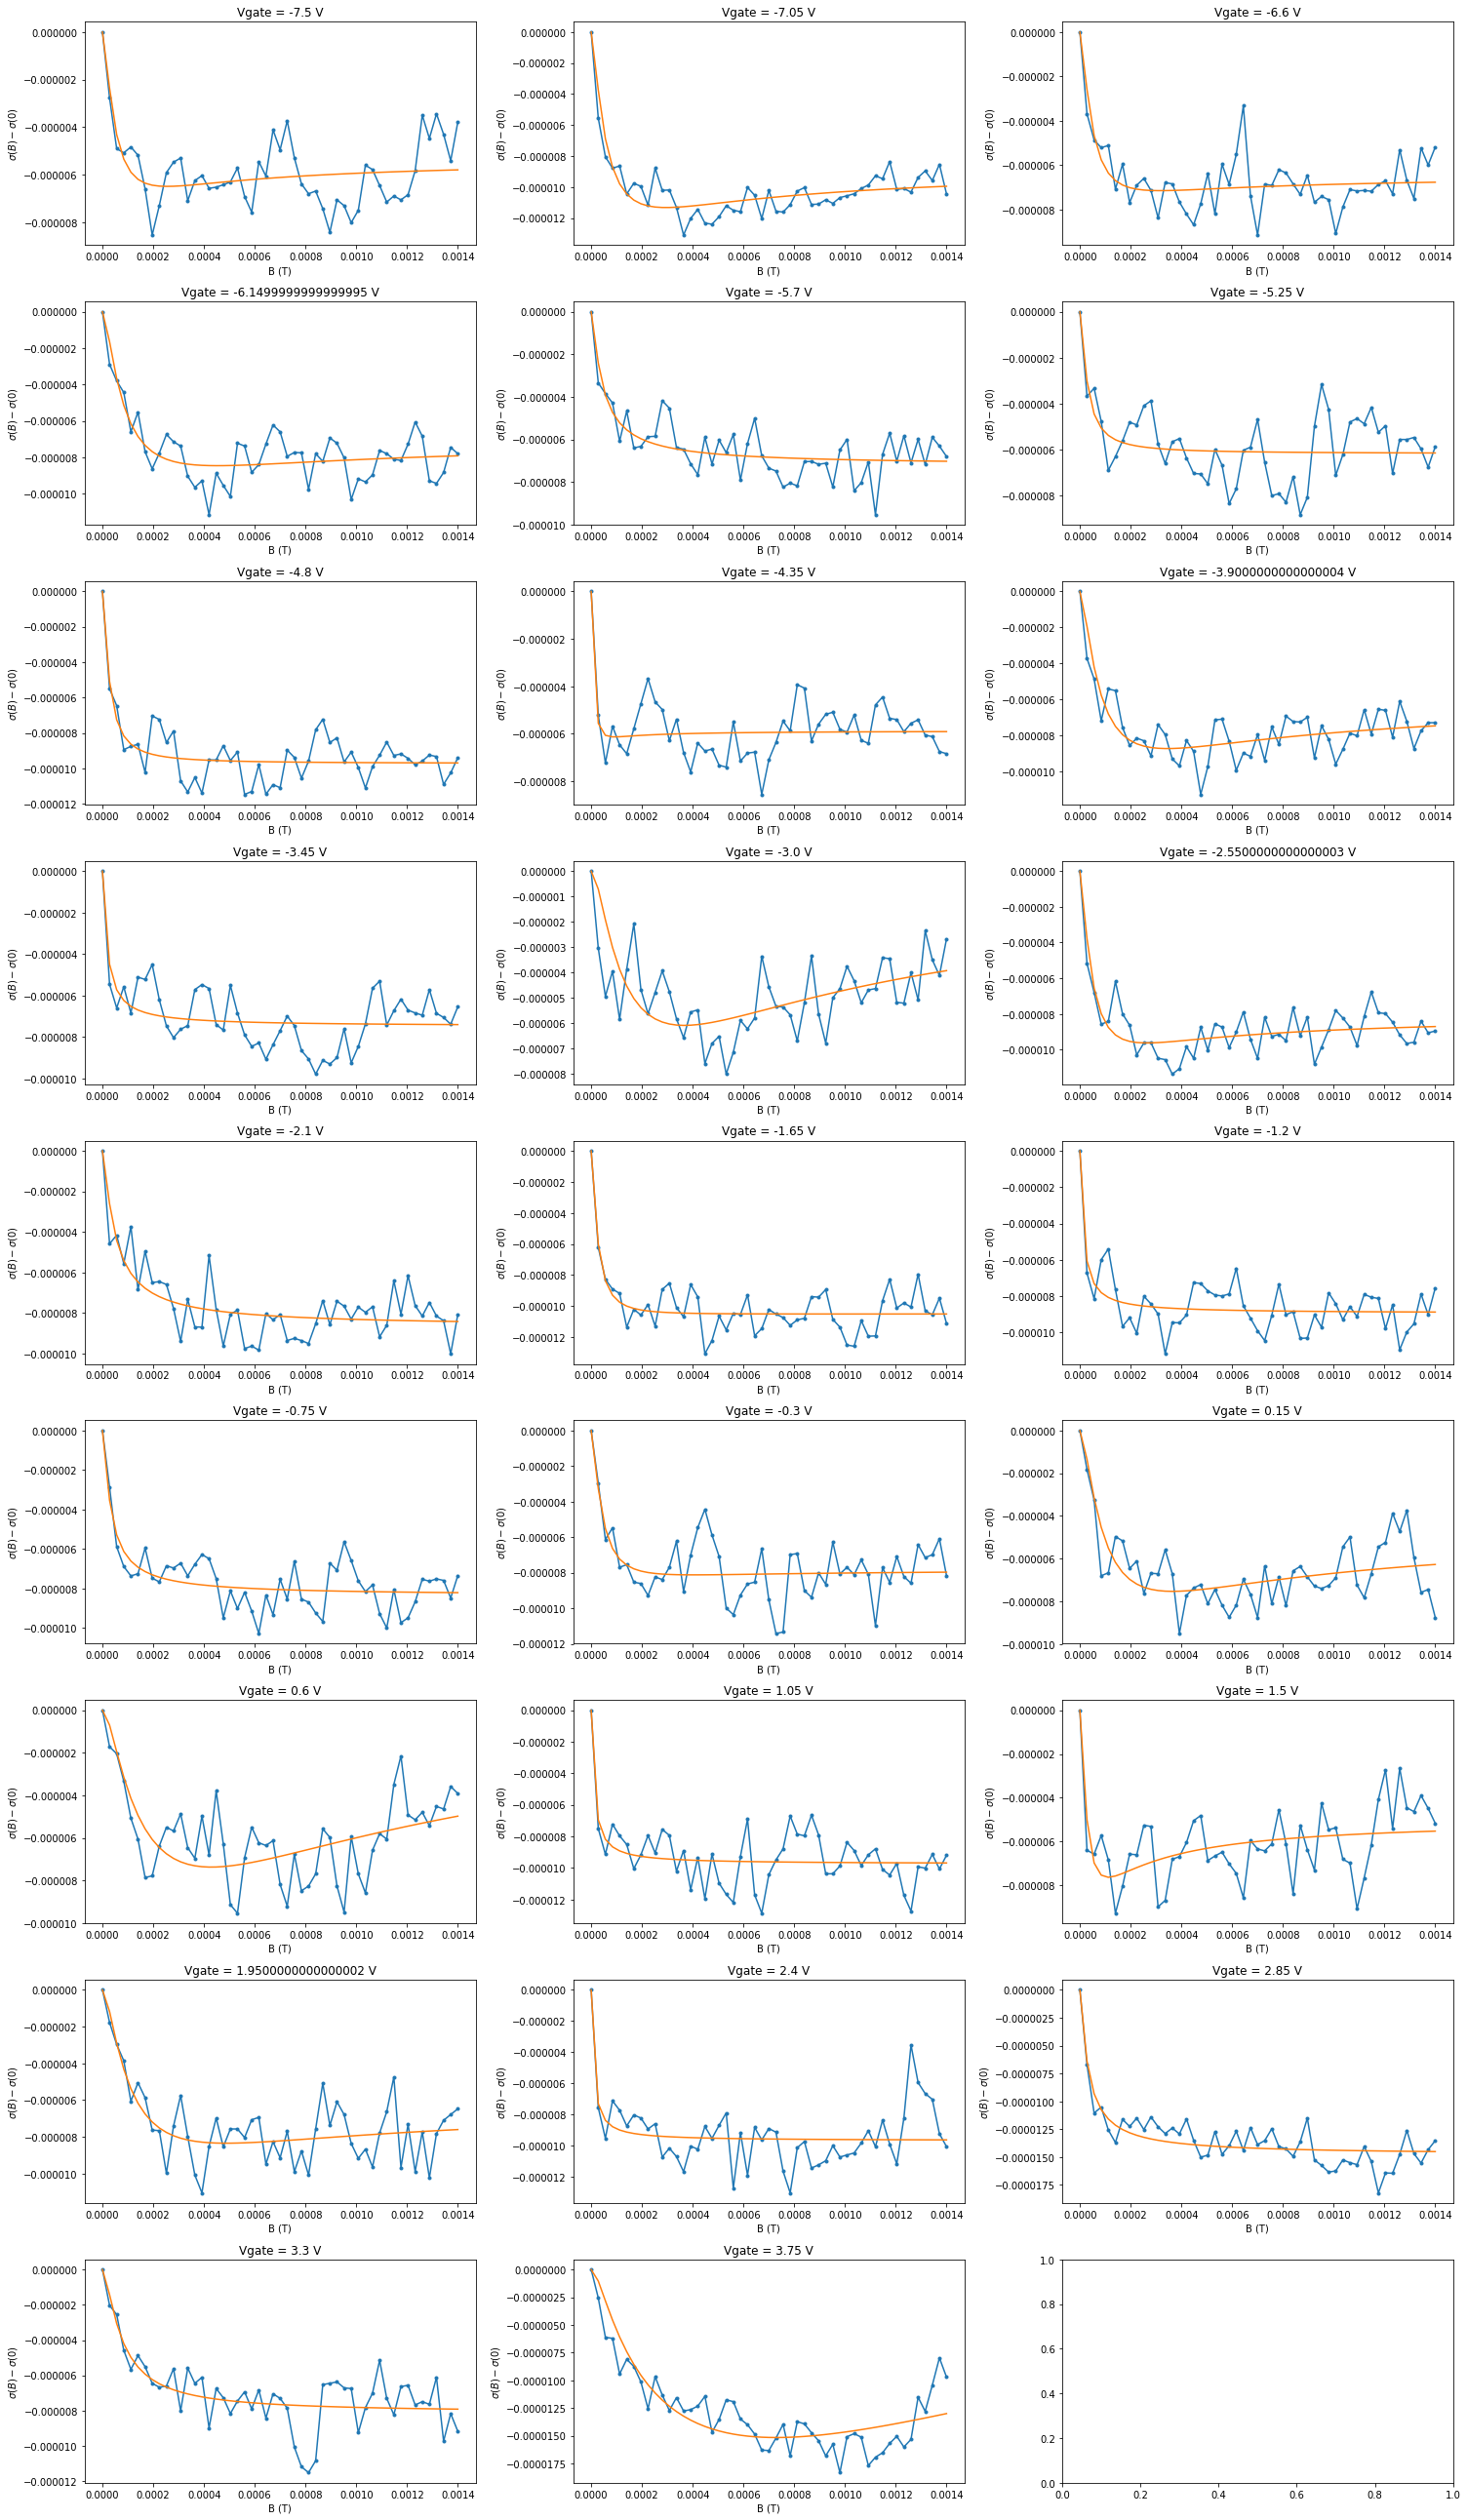

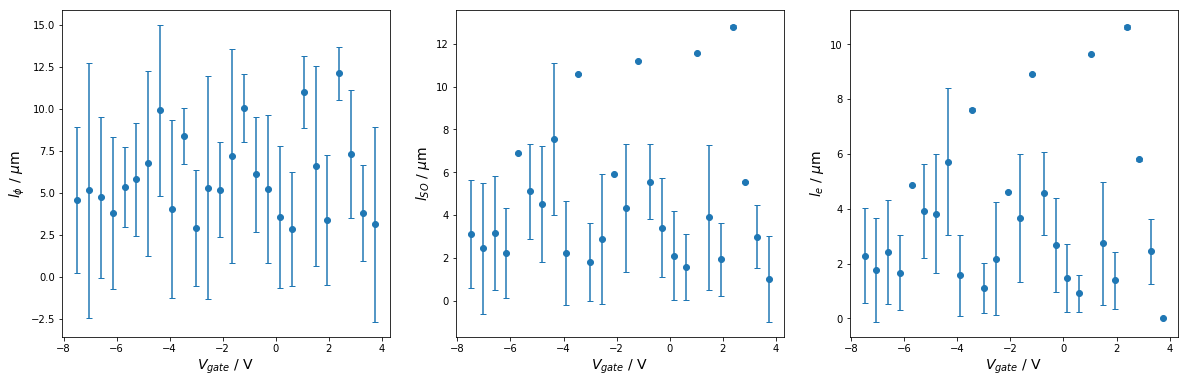

Mean values:
l_phi = 5.92 +- 4.13 um
l_SO = 4.85 +- 1.76 um
l_e = 3.78 +- 1.16 um


In [20]:
#Plotting
subfigs = np.ceil(df['0087']['Gate dac 2 / mV'].unique().size)
if subfigs <= 3:
    rows,cols = 1,int(subfigs)
else:
    rows,cols = int(np.ceil(subfigs/3)),3
fig_wal,ax_wal = plt.subplots(nrows=rows,ncols=cols,figsize=(cols*7,rows*4))
ax_wal = sum(ax_wal.tolist(), [])

#Save fit data prep
l_fits = {}
l_fits_error = {}
l_vgate = []
for ax,(label,group) in zip(ax_wal,df['0087'].groupby('Gate dac 2 / mV')):
    B = np.linspace(1e-8,1.4e-3,51)
    offset = group['Magnet Z / T'][group['AC Voltage xx / V'].idxmin()]
    G = WAL_data(B,group['Magnet Z / T']-offset,group['AC Voltage xx / V'],4e-9)
    
    #Fitting
    p0 = [hbar/(4*e*l**2) for l in [2e-6,2e-6,2e-6]]
    popt,pcov = scipy.optimize.curve_fit(WAL_model,B,G,p0=p0)   
    
    #Save fit data
    l_vgate.append(label/1e3*15)
    l_all = [1/np.sqrt(4*e*B/hbar) for B in popt]
    l_errors = [1/np.sqrt(4*e*B/hbar)/2 for B in np.sqrt(np.diag(pcov))]
    for dic,vals in zip([l_fits,l_fits_error],[l_all,l_errors]):
        for key,l in zip(['l_phi','l_SO','l_e'],vals):
            if key in dic:
                dic[key].append(l)
            else:
                dic[key] = [l]
                
    #Plotting
    ax.plot(B,G,'.-')
    ax.plot(B,WAL_model(B,*popt))
    ax.set_title('Vgate = {} V'.format(label/1e3*15))
    ax.set_xlabel('B (T)')
    ax.set_ylabel(u'$\sigma(B) - \sigma(0)$')
fig_wal.tight_layout()

#Fitted values
fig, axes = plt.subplots(figsize=(20,6),ncols=3)
ylabels = [u'$l_\phi$ / $\mu$m',u'$l_{SO}$ / $\mu$m',u'$l_{e}$ / $\mu$m']

for ax,(_,ls),(__,ls_error),ylabel in zip(axes,l_fits.items(),l_fits_error.items(),ylabels):
    ax.errorbar(l_vgate,np.array(ls)*1e6,yerr=np.array(ls_error)*1e6,fmt='o',capsize=3)
    ax.set_xlabel(u'$V_{gate}$ / V', fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
plt.show()

l_mean = [np.mean(l)*1e6 for _,l in l_fits.items()]
l_mean_error = [np.mean(l)*1e6 for _,l in l_fits_error.items()]
print('Mean values:\nl_phi = {0:.2f} +- {3:.2f} um\nl_SO = {1:.2f} +- {4:.2f} um\nl_e = {2:.2f} +- {5:.2f} um'.format(*l_mean+l_mean_error))

In [7]:
a = list(map(lambda x: json.loads(x) if len(x)>0 else {},codecs.open('../data/20180706T154850269Z-0103.json.jsonl').read().split('\n')))
df = pd.DataFrame(a)

# Misc

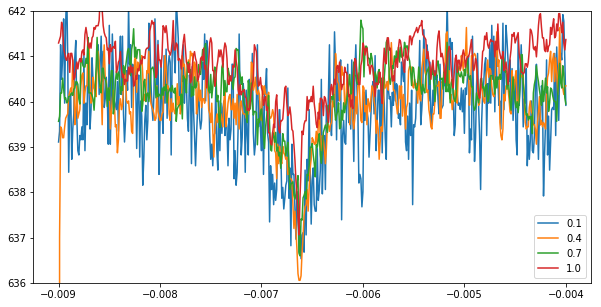

In [3]:
loadin('20180704T113230610Z-0084.json')
tdf = [df['0084'][df['0084']['Lockin 1 amplitude / V'] == amp] for amp in np.linspace(0.1,0.7,3)]
fig_1, ax_1 = plt.subplots(figsize=(10,5))
for tmpdf in tdf:
    B = tmpdf['Magnet Z / T']
    Vxx = tmpdf['AC Voltage xx / V']/(tmpdf['Lockin 1 amplitude / V'].values[0]/100*1e-6)
    ax_1.plot(B,Vxx,label=str(tmpdf['Lockin 1 amplitude / V'].values[0]))

loadin('20180704T081141439Z-0082.json')
B = df['0082']['Magnet Z / T']
Vxx = df['0082']['AC Voltage xx / V']/10e-9
ax_1.plot(B,Vxx,label='1.0')
# ax_1.set_xlim([-7e-3,-6e-3])
ax_1.set_ylim([636,642])
plt.legend()

l_phi = 3.80e-07 m, l_SO = 3.80e-07 m, l_e = 3.80e-07 m.
l_phi = 1.07e-06 m, l_SO = 1.07e-06 m, l_e = 1.07e-06 m.


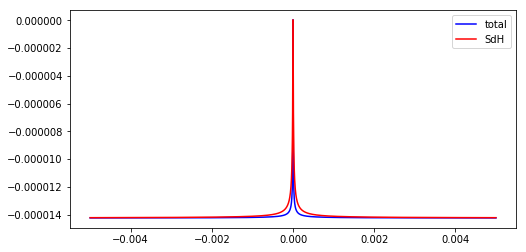

In [6]:
# Params
n = [3.4868766066386916e+16, 4880469527036150.5]
mu = [1.2323580034423407, 9.248209116291958]
le = [mu*h*np.sqrt(n) / (np.sqrt(2*np.pi) * e) for n,mu in zip(n,mu)]
Be = np.array([hbar/(4*e*i**2) for i in le])
Bphi = np.array([i for i in 1*Be])
Bso = np.array([i for i in 1*Be])
l = [1/np.sqrt(4*e*i/hbar) for i in [Bphi,Bso,Be]]

B = np.linspace(1e-9,5e-3,1001)

fig, ax = plt.subplots(figsize=(8,4))
for ii,clr,lbl in zip([0,1],['b','r'],['total','SdH']):
    print('l_phi = {0:.2e} m, l_SO = {1:.2e} m, l_e = {2:.2e} m.'.format(*(i[ii] for i in l)))
    cond = WAL_model(B,*[i[ii] for i in l])
    # Plot
    ax.plot(B,cond,color=clr,label=lbl)
    ax.plot(-B[::-1],cond[::-1],color=clr)
ax.legend(loc="upper right")